EOD strategies could be rebalanced max once per week to consider brokerage and other costs 

We can use the momentum logic to create a ranking logic for a possible long-short equity algo. This could be done on futures so that we would be market neutral to some extent. 
The idea is to pick top ranks from 
1) stocks that are having positive momentum - bullish 
2) stocks that have negative momentum - bearish 

So at any point if market decides to go up or down as systematic risk our exposures will be managed

Additionally we can explore the ADX indicator to see if it is acting as a confirmation to our momentum stock picks 
We could also reduce the frequency of 6month testing to a quarter or maybe 1 month too so that we don’t enter in the stock too late

Strategy:
1.	Lookback period – 126 plus 1st Tuesday after that
2.	Need to run very Tuesday of the week
3.	Initial Capital – 200000
4.	Weighting – Equal wts

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
import datetime
import pandas as pd
import numpy as np
idx = pd.IndexSlice

In [3]:
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import investpy
import pyfolio as pf
import backtrader as bt
import collections
from scipy.stats import linregress

C:\Users\Admin\AppData\Roaming\Python\Python38\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [4]:
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
np.random.seed(42)
bt.__version__

'1.9.76.123'

In [5]:
DATA_STORE = '../../Data-Daily/india_asset.h5'

In [6]:
with pd.HDFStore(DATA_STORE) as store:
    nifty200_m = (store['/nse/nifty200/metadata'])
tickers = nifty200_m.dropna().symbol.to_list()
print(len(tickers))

197


In [7]:
columns = ['close','high','low','open','volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = store['/ind/nifty500_investing/prices'].loc[idx[tickers, :], columns]
prices.head(3)

close    high    low   open   volume
ticker date                                             
ACC    2000-01-03  268.55  271.45  255.1  258.9  5447617
       2000-01-04  256.60  269.50  255.1  268.0  2978528
       2000-01-05  250.30  268.00  244.5  249.9  2802364

In [8]:
# remove tickers where we have less than 10 years of data.
min_obs =  2520
nobs = prices.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index
prices = prices.loc[idx[keep,:], :]
prices.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 621400 entries, ('ABOT', Timestamp('2000-01-03 00:00:00')) to ('ZEE', Timestamp('2021-01-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   close   621400 non-null  float64
 1   high    621400 non-null  float64
 2   low     621400 non-null  float64
 3   open    621400 non-null  float64
 4   volume  621400 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 26.3+ MB


In [9]:
prices.index.unique(level='ticker')

Index(['ABOT', 'ABUJ', 'ACC', 'ADEL', 'AMAR', 'APLH', 'APLO', 'APSE', 'ARBN',
       'ARTI',
       ...
       'ULTC', 'UNBK', 'UNSP', 'UPLL', 'VGUA', 'VODA', 'VOLT', 'WHIR', 'WIPR',
       'ZEE'],
      dtype='object', name='ticker', length=154)

In [10]:
fromdate=datetime.datetime(2010, 1, 1)
todate=datetime.datetime(2021, 1, 21)

In [11]:
# Calculate momentum
def momentum_func(self, the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = (1 + slope) ** 252
    return annualized * (rvalue ** 2)

In [12]:
class Momentum(bt.ind.OperationN):
    lines = ('trend',)
    params = dict(period=126)
    func = momentum_func

In [13]:
class StrategyEqWt(bt.Strategy):
    params = dict(
        # parametrize the Momentum and its period
        momentum=Momentum,
        momentum_period=90,
        num_positions=20,
        rebalance_days = [1],

        printlog=False,
        reserve=0.00  # 5% reserve capital
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function '''
        if self.params.printlog or doprint:
            dt = dt or self.data.datetime[0]
            if isinstance(dt, float):
                dt = bt.num2date(dt)
            print("%s, %s" % (dt.isoformat(), txt))

    def __init__(self):
        self.securities = self.datas
        self.inds = collections.defaultdict(dict)
        for d in self.datas:
            self.inds[d]['mom'] = self.p.momentum(d, period=self.p.momentum_period)
            self.inds[d]['adx'] = bt.indicators.ADX(d, period=14)
# #             self.inds[d]['rsi'] = bt.indicators.RSI(d, period=14)
#             self.inds[d]['MACD'] = bt.indicators.MACD(d)
#             # Cross of macd.macd and macd.signal
#             self.inds[d]['mcross'] = bt.indicators.CrossOver(self.inds[d]['MACD'].macd, self.inds[d]['MACD'].signal)
            

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

    def rebalance(self):
        rankings = list(self.securities)
        rankings.sort(key=lambda s: self.inds[s]['mom'][0], reverse=True)

        # allocation perc per stock
        # reserve kept to make sure orders are not rejected due to
        # margin. Prices are calculated when known (close), but orders can only
        # be executed next day (opening price). Price can gap upwards
        pos_size = (1.0 - self.p.reserve) / self.p.num_positions

        # Sell stocks no longer meeting ranking filter.
        for i, d in enumerate(rankings):
            if self.getposition(d).size:
                if i > self.p.num_positions:
                    self.close(d)
                    self.log('Leave {} - Rank {:.2f}'.format(d._name, i)) 
        
        # Buy and rebalance stocks with remaining cash
        for i, d in enumerate(rankings[:self.p.num_positions]):
            cash = self.broker.get_cash()
            if cash <= 0:
                break
            if not self.getposition(d).size:
                if (self.inds[d]['adx'][0] > 25): #(self.inds[d]['rsi'][0] < 25): #and (self.inds[d]['rsi'][-1] > 25) and (self.inds[d]['adx'][0] < 25):
                    self.order_target_percent(d, target=pos_size)
                    self.log('Buy {} - Rank {:.2f} - Close {:.2f}'.format(d._name, i, d.close[0])) 
                
    def next_open(self):
        dt = self.data.datetime.datetime()
        if dt.weekday() in self.p.rebalance_days:
            self.rebalance()

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price, order.executed.value, order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price, order.executed.value,order.executed.comm))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None
    
    def stop(self):
        self.log('| %2d | %2d |  %.2f |' %
                 (self.p.momentum_period, self.p.num_positions, self.broker.getvalue()), doprint=False)

In [14]:
# Model Settings
startcash = 200000
momentum_period = 126 #days
num_positions = 20 
rebalance_days = [1]
reserve = 0.05
printlog=True


# Commission and Slippage Settings
commission = 0.0025

In [15]:
cerebro = bt.Cerebro(stdstats=False,cheat_on_open=True)
# cerebro.broker.set_coc(True)
cerebro.broker.setcash(startcash)
cerebro.broker.setcommission(commission=commission)

In [16]:
# Add securities as datas1:
for ticker, data in prices.groupby(level=0):
    if ticker in tickers:
        print(f"Adding ticker: {ticker}")
        data = bt.feeds.PandasData(dataname=data.droplevel(level=0),
                                   name=str(ticker),
                                   fromdate=fromdate,
                                   todate=todate,
                                   plot=False)
        cerebro.adddata(data)

Adding ticker: ABOT
Adding ticker: ABUJ
Adding ticker: ACC
Adding ticker: ADEL
Adding ticker: AMAR
Adding ticker: APLH
Adding ticker: APLO
Adding ticker: APSE
Adding ticker: ARBN
Adding ticker: ARTI
Adding ticker: ASOK
Adding ticker: ASPN
Adding ticker: AXBK
Adding ticker: BAJA
Adding ticker: BAJE
Adding ticker: BATA
Adding ticker: BBRM
Adding ticker: BFRG
Adding ticker: BHEL
Adding ticker: BION
Adding ticker: BJAT
Adding ticker: BJFN
Adding ticker: BJFS
Adding ticker: BLKI
Adding ticker: BOB
Adding ticker: BOI
Adding ticker: BOSH
Adding ticker: BPCL
Adding ticker: BRGR
Adding ticker: BRIT
Adding ticker: BRTI
Adding ticker: CADI
Adding ticker: CAST
Adding ticker: CCRI
Adding ticker: CESC
Adding ticker: CHLA
Adding ticker: CNBK
Adding ticker: COAL
Adding ticker: COLG
Adding ticker: CORF
Adding ticker: CTBK
Adding ticker: CUMM
Adding ticker: DABU
Adding ticker: DIVI
Adding ticker: DLF
Adding ticker: EDEL
Adding ticker: EMAM
Adding ticker: ESCO
Adding ticker: EXID
Adding ticker: FED
Addin

In [17]:
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

cerebro.addstrategy(StrategyEqWt,
                    momentum_period = momentum_period,
                    num_positions = num_positions,
                    rebalance_days = rebalance_days,
                    printlog = printlog,
                    reserve = reserve
                   )

0

In [18]:
%%time
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Run the strategy. Results will be output from stop.
results_eq_wts = cerebro.run()

# Print out the final result
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 200000.00
2011-05-17T00:00:00, Buy PIIL - Rank 0.00 - Close 71.07
2011-05-17T00:00:00, Buy PFIZ - Rank 1.00 - Close 1260.80
2011-05-17T00:00:00, Buy MOSS - Rank 2.00 - Close 27.58
2011-05-17T00:00:00, Buy COAL - Rank 5.00 - Close 397.60
2011-05-17T00:00:00, Buy HZNC - Rank 6.00 - Close 103.74
2011-05-17T00:00:00, Buy BATA - Rank 8.00 - Close 236.93
2011-05-17T00:00:00, Buy CADI - Rank 9.00 - Close 177.95
2011-05-17T00:00:00, Buy CESC - Rank 12.00 - Close 214.29
2011-05-17T00:00:00, Buy BHEL - Rank 13.00 - Close 274.07
2011-05-17T00:00:00, Buy UBBW - Rank 14.00 - Close 550.30
2011-05-17T00:00:00, Buy GLEN - Rank 18.00 - Close 304.20
2011-05-17T00:00:00, BUY EXECUTED, Price: 70.00, Cost: 9310.00, Comm 23.28
2011-05-17T00:00:00, BUY EXECUTED, Price: 1260.00, Cost: 8820.00, Comm 22.05
2011-05-17T00:00:00, BUY EXECUTED, Price: 27.47, Cost: 9449.68, Comm 23.62
2011-05-17T00:00:00, BUY EXECUTED, Price: 390.00, Cost: 8970.00, Comm 22.43
2011-05-17T00:00:00, BUY EXECUT

2011-10-04T00:00:00, SELL EXECUTED, Price: 109.25, Cost: 9522.27, Comm 25.40
2011-10-11T00:00:00, Leave AMAR - Rank 26.00
2011-10-11T00:00:00, Buy MAXI - Rank 11.00 - Close 177.95
2011-10-11T00:00:00, SELL EXECUTED, Price: 102.00, Cost: 10643.60, Comm 22.44
2011-10-11T00:00:00, BUY EXECUTED, Price: 178.50, Cost: 9639.00, Comm 24.10
2011-10-18T00:00:00, Buy REXP - Rank 5.00 - Close 144.25
2011-10-18T00:00:00, Buy LUPN - Rank 17.00 - Close 467.55
2011-10-18T00:00:00, BUY EXECUTED, Price: 139.00, Cost: 9591.00, Comm 23.98
2011-10-18T00:00:00, BUY EXECUTED, Price: 457.50, Cost: 9607.50, Comm 24.02
2011-10-25T00:00:00, Leave ASPN - Rank 23.00
2011-10-25T00:00:00, Leave JUBI - Rank 28.00
2011-10-25T00:00:00, SELL EXECUTED, Price: 304.51, Cost: 10166.40, Comm 24.36
2011-10-25T00:00:00, SELL EXECUTED, Price: 428.95, Cost: 9329.95, Comm 24.66
2011-11-01T00:00:00, Leave BRIT - Rank 29.00
2011-11-01T00:00:00, Buy TVSM - Rank 14.00 - Close 66.00
2011-11-01T00:00:00, SELL EXECUTED, Price: 235.00, C

2012-03-27T00:00:00, Leave ACC - Rank 24.00
2012-03-27T00:00:00, Leave REDY - Rank 25.00
2012-03-27T00:00:00, Leave ZEE - Rank 29.00
2012-03-27T00:00:00, Leave TCS - Rank 33.00
2012-03-27T00:00:00, Buy IPCA - Rank 6.00 - Close 331.70
2012-03-27T00:00:00, Buy BLKI - Rank 16.00 - Close 120.32
2012-03-27T00:00:00, Buy UBBW - Rank 19.00 - Close 538.90
2012-03-27T00:00:00, SELL EXECUTED, Price: 1335.00, Cost: 9601.20, Comm 26.70
2012-03-27T00:00:00, SELL EXECUTED, Price: 1675.25, Cost: 8301.25, Comm 20.94
2012-03-27T00:00:00, SELL EXECUTED, Price: 127.00, Cost: 9836.75, Comm 23.18
2012-03-27T00:00:00, SELL EXECUTED, Price: 566.21, Cost: 8596.00, Comm 22.65
2012-03-27T00:00:00, BUY EXECUTED, Price: 339.80, Cost: 10194.00, Comm 25.48
2012-03-27T00:00:00, BUY EXECUTED, Price: 119.50, Cost: 9799.00, Comm 24.50
2012-03-27T00:00:00, BUY EXECUTED, Price: 540.95, Cost: 9737.10, Comm 24.34
2012-04-03T00:00:00, Leave GRAS - Rank 22.00
2012-04-03T00:00:00, Leave LICH - Rank 23.00
2012-04-03T00:00:00, 

2012-10-30T00:00:00, Leave DIVI - Rank 26.00
2012-10-30T00:00:00, Buy UBBW - Rank 19.00 - Close 746.50
2012-10-30T00:00:00, SELL EXECUTED, Price: 1163.65, Cost: 9108.00, Comm 26.18
2012-10-30T00:00:00, BUY EXECUTED, Price: 760.00, Cost: 10640.00, Comm 26.60
2012-11-06T00:00:00, Leave TREN - Rank 24.00
2012-11-06T00:00:00, Buy MOSS - Rank 16.00 - Close 30.81
2012-11-06T00:00:00, Buy MAHM - Rank 19.00 - Close 457.29
2012-11-06T00:00:00, SELL EXECUTED, Price: 115.17, Cost: 10466.84, Comm 26.49
2012-11-06T00:00:00, BUY EXECUTED, Price: 30.37, Cost: 10781.35, Comm 26.95
2012-11-06T00:00:00, BUY EXECUTED, Price: 452.81, Cost: 10414.63, Comm 26.04
2012-11-13T00:00:00, Leave GOCP - Rank 23.00
2012-11-13T00:00:00, Buy ARBN - Rank 18.00 - Close 89.22
2012-11-13T00:00:00, SELL EXECUTED, Price: 345.50, Cost: 9724.00, Comm 29.37
2012-11-13T00:00:00, BUY EXECUTED, Price: 89.50, Cost: 11456.00, Comm 28.64
2012-11-27T00:00:00, Leave HLL - Rank 24.00
2012-11-27T00:00:00, Buy HCLT - Rank 18.00 - Close 1

2013-04-23T00:00:00, Leave TEML - Rank 22.00
2013-04-23T00:00:00, Leave CHLA - Rank 23.00
2013-04-23T00:00:00, Leave MOSS - Rank 29.00
2013-04-23T00:00:00, Buy INFY - Rank 16.00 - Close 280.56
2013-04-23T00:00:00, Buy LUPN - Rank 19.00 - Close 680.10
2013-04-23T00:00:00, SELL EXECUTED, Price: 458.82, Cost: 10532.06, Comm 25.24
2013-04-23T00:00:00, SELL EXECUTED, Price: 52.20, Cost: 10920.00, Comm 27.41
2013-04-23T00:00:00, SELL EXECUTED, Price: 37.53, Cost: 10781.35, Comm 33.31
2013-04-23T00:00:00, BUY EXECUTED, Price: 279.04, Cost: 10882.56, Comm 27.21
2013-04-23T00:00:00, BUY EXECUTED, Price: 685.00, Cost: 10960.00, Comm 27.40
2013-04-30T00:00:00, Leave INFY - Rank 49.00
2013-04-30T00:00:00, Buy WIPR - Rank 8.00 - Close 174.18
2013-04-30T00:00:00, Buy BPCL - Rank 18.00 - Close 134.79
2013-04-30T00:00:00, Buy BRIT - Rank 19.00 - Close 289.93
2013-04-30T00:00:00, SELL EXECUTED, Price: 277.06, Cost: 10882.56, Comm 27.01
2013-04-30T00:00:00, BUY EXECUTED, Price: 172.07, Cost: 10840.41, C

2013-11-05T00:00:00, Leave DABU - Rank 21.00
2013-11-05T00:00:00, Buy PIIL - Rank 15.00 - Close 204.90
2013-11-05T00:00:00, Buy MOSS - Rank 19.00 - Close 54.07
2013-11-05T00:00:00, Order Canceled/Margin/Rejected
2013-11-05T00:00:00, SELL EXECUTED, Price: 177.45, Cost: 10902.00, Comm 30.61
2013-11-05T00:00:00, BUY EXECUTED, Price: 213.00, Cost: 13206.00, Comm 33.02
2013-11-12T00:00:00, Leave IPCA - Rank 21.00
2013-11-12T00:00:00, Buy BFRG - Rank 17.00 - Close 144.12
2013-11-12T00:00:00, Buy MOSS - Rank 19.00 - Close 52.44
2013-11-12T00:00:00, Order Canceled/Margin/Rejected
2013-11-12T00:00:00, SELL EXECUTED, Price: 701.00, Cost: 11525.40, Comm 33.30
2013-11-12T00:00:00, BUY EXECUTED, Price: 143.95, Cost: 12667.60, Comm 31.67
2013-11-19T00:00:00, Leave LUPN - Rank 23.00
2013-11-19T00:00:00, Buy MOSS - Rank 18.00 - Close 52.09
2013-11-19T00:00:00, Buy ARBN - Rank 19.00 - Close 139.30
2013-11-19T00:00:00, Order Canceled/Margin/Rejected
2013-11-19T00:00:00, SELL EXECUTED, Price: 858.00, Cos

2014-04-15T00:00:00, Leave PIIL - Rank 24.00
2014-04-15T00:00:00, Buy IOC - Rank 15.00 - Close 66.59
2014-04-15T00:00:00, Buy MRF - Rank 18.00 - Close 23464.20
2014-04-15T00:00:00, SELL EXECUTED, Price: 256.60, Cost: 13206.00, Comm 39.77
2014-04-15T00:00:00, BUY EXECUTED, Price: 68.04, Cost: 16193.52, Comm 40.48
2014-04-22T00:00:00, Leave DIVI - Rank 22.00
2014-04-22T00:00:00, Buy MRF - Rank 16.00 - Close 22228.60
2014-04-22T00:00:00, Buy CESC - Rank 17.00 - Close 395.82
2014-04-22T00:00:00, Buy CUMM - Rank 19.00 - Close 572.85
2014-04-22T00:00:00, Order Canceled/Margin/Rejected
2014-04-22T00:00:00, SELL EXECUTED, Price: 674.33, Cost: 14401.00, Comm 33.72
2014-04-22T00:00:00, BUY EXECUTED, Price: 400.29, Cost: 16011.60, Comm 40.03
2014-04-29T00:00:00, Leave PAGE - Rank 21.00
2014-04-29T00:00:00, Buy CUMM - Rank 16.00 - Close 550.15
2014-04-29T00:00:00, Buy MRF - Rank 19.00 - Close 20721.55
2014-04-29T00:00:00, Order Canceled/Margin/Rejected
2014-04-29T00:00:00, SELL EXECUTED, Price: 58

2014-09-09T00:00:00, Buy PIIL - Rank 12.00 - Close 471.10
2014-09-09T00:00:00, BUY EXECUTED, Price: 462.00, Cost: 21252.00, Comm 53.13
2014-09-16T00:00:00, Leave REXP - Rank 24.00
2014-09-16T00:00:00, Leave GGAS - Rank 31.00
2014-09-16T00:00:00, Buy MOSS - Rank 12.00 - Close 122.87
2014-09-16T00:00:00, Buy CHLA - Rank 15.00 - Close 96.14
2014-09-16T00:00:00, Buy NATP - Rank 17.00 - Close 308.65
2014-09-16T00:00:00, Buy BRGR - Rank 19.00 - Close 124.63
2014-09-16T00:00:00, Order Canceled/Margin/Rejected
2014-09-16T00:00:00, SELL EXECUTED, Price: 154.30, Cost: 19635.00, Comm 40.50
2014-09-16T00:00:00, SELL EXECUTED, Price: 520.90, Cost: 23535.00, Comm 58.60
2014-09-16T00:00:00, BUY EXECUTED, Price: 130.07, Cost: 23542.67, Comm 58.86
2014-09-16T00:00:00, BUY EXECUTED, Price: 99.60, Cost: 23107.20, Comm 57.77
2014-09-16T00:00:00, BUY EXECUTED, Price: 312.81, Cost: 22522.32, Comm 56.31
2014-09-23T00:00:00, Leave EDEL - Rank 23.00
2014-09-23T00:00:00, Buy BRGR - Rank 17.00 - Close 125.80
201

2015-03-17T00:00:00, Buy EMAM - Rank 19.00 - Close 538.88
2015-03-17T00:00:00, BUY EXECUTED, Price: 535.15, Cost: 26757.50, Comm 66.89
2015-03-24T00:00:00, Buy SIEM - Rank 13.00 - Close 1338.70
2015-03-24T00:00:00, BUY EXECUTED, Price: 1337.00, Cost: 26740.00, Comm 66.85
2015-03-31T00:00:00, Buy PIIL - Rank 14.00 - Close 608.70
2015-03-31T00:00:00, BUY EXECUTED, Price: 629.85, Cost: 27713.40, Comm 69.28
2015-04-07T00:00:00, Leave AMAR - Rank 21.00
2015-04-07T00:00:00, SELL EXECUTED, Price: 859.90, Cost: 20213.00, Comm 73.09
2015-04-21T00:00:00, Leave BBRM - Rank 21.00
2015-04-21T00:00:00, Leave AXBK - Rank 27.00
2015-04-21T00:00:00, Buy UBBW - Rank 7.00 - Close 1070.70
2015-04-21T00:00:00, Buy INDB - Rank 10.00 - Close 38.40
2015-04-21T00:00:00, Buy NAFL - Rank 14.00 - Close 177.71
2015-04-21T00:00:00, Buy LUPN - Rank 18.00 - Close 1759.65
2015-04-21T00:00:00, SELL EXECUTED, Price: 447.50, Cost: 20349.00, Comm 114.11
2015-04-21T00:00:00, SELL EXECUTED, Price: 518.25, Cost: 25157.40, Co

2015-10-20T00:00:00, Leave GLEN - Rank 24.00
2015-10-20T00:00:00, SELL EXECUTED, Price: 1042.10, Cost: 26757.00, Comm 70.34
2015-10-27T00:00:00, Leave HPCL - Rank 25.00
2015-10-27T00:00:00, Buy ESCO - Rank 4.00 - Close 178.90
2015-10-27T00:00:00, SELL EXECUTED, Price: 172.00, Cost: 27252.96, Comm 72.24
2015-10-27T00:00:00, BUY EXECUTED, Price: 179.25, Cost: 30114.00, Comm 75.28
2015-11-03T00:00:00, Buy IGAS - Rank 17.00 - Close 96.82
2015-11-03T00:00:00, Buy INFY - Rank 18.00 - Close 568.26
2015-11-03T00:00:00, BUY EXECUTED, Price: 97.88, Cost: 31027.96, Comm 77.57
2015-11-03T00:00:00, BUY EXECUTED, Price: 562.25, Cost: 30361.50, Comm 75.90
2015-11-17T00:00:00, Leave INFY - Rank 22.00
2015-11-17T00:00:00, SELL EXECUTED, Price: 535.76, Cost: 30361.50, Comm 72.33
2015-11-24T00:00:00, Leave BRIT - Rank 23.00
2015-11-24T00:00:00, Leave CUMM - Rank 25.00
2015-11-24T00:00:00, Buy TREN - Rank 12.00 - Close 145.50
2015-11-24T00:00:00, Buy MBFL - Rank 17.00 - Close 515.50
2015-11-24T00:00:00, S

2016-05-31T00:00:00, Leave IGAS - Rank 22.00
2016-05-31T00:00:00, Leave TOPO - Rank 40.00
2016-05-31T00:00:00, Buy PIRA - Rank 12.00 - Close 1437.33
2016-05-31T00:00:00, Buy PIDI - Rank 14.00 - Close 706.25
2016-05-31T00:00:00, SELL EXECUTED, Price: 113.80, Cost: 29359.20, Comm 73.97
2016-05-31T00:00:00, SELL EXECUTED, Price: 183.45, Cost: 31500.00, Comm 64.21
2016-05-31T00:00:00, BUY EXECUTED, Price: 1388.86, Cost: 29166.06, Comm 72.92
2016-05-31T00:00:00, BUY EXECUTED, Price: 693.10, Cost: 30496.40, Comm 76.24
2016-06-07T00:00:00, Buy MMFS - Rank 19.00 - Close 330.50
2016-06-07T00:00:00, BUY EXECUTED, Price: 329.70, Cost: 31651.20, Comm 79.13
2016-06-14T00:00:00, Buy CORF - Rank 14.00 - Close 255.30
2016-06-14T00:00:00, Buy HROM - Rank 18.00 - Close 3005.80
2016-06-14T00:00:00, Buy HALC - Rank 19.00 - Close 115.60
2016-06-14T00:00:00, BUY EXECUTED, Price: 260.00, Cost: 31980.00, Comm 79.95
2016-06-14T00:00:00, BUY EXECUTED, Price: 3040.00, Cost: 30400.00, Comm 76.00
2016-06-14T00:00:

2016-12-20T00:00:00, Leave BJFS - Rank 23.00
2016-12-20T00:00:00, Leave PNBK - Rank 34.00
2016-12-20T00:00:00, SELL EXECUTED, Price: 2746.95, Cost: 36150.40, Comm 89.28
2016-12-20T00:00:00, SELL EXECUTED, Price: 124.90, Cost: 38752.00, Comm 87.43
2016-12-27T00:00:00, Leave ESCO - Rank 27.00
2016-12-27T00:00:00, SELL EXECUTED, Price: 281.00, Cost: 33127.50, Comm 105.38
2017-01-03T00:00:00, Leave CNBK - Rank 22.00
2017-01-03T00:00:00, Leave BJAT - Rank 28.00
2017-01-03T00:00:00, Buy PWFC - Rank 15.00 - Close 125.20
2017-01-03T00:00:00, SELL EXECUTED, Price: 254.54, Cost: 38819.30, Comm 82.73
2017-01-03T00:00:00, SELL EXECUTED, Price: 1825.00, Cost: 35359.15, Comm 77.56
2017-01-03T00:00:00, BUY EXECUTED, Price: 124.00, Cost: 34968.00, Comm 87.42
2017-01-17T00:00:00, Buy NMDC - Rank 5.00 - Close 143.10
2017-01-17T00:00:00, Buy NALU - Rank 6.00 - Close 68.85
2017-01-17T00:00:00, BUY EXECUTED, Price: 144.40, Cost: 37110.80, Comm 92.78
2017-01-17T00:00:00, BUY EXECUTED, Price: 70.35, Cost: 37

2017-06-13T00:00:00, Leave CESC - Rank 26.00
2017-06-13T00:00:00, Buy VOLT - Rank 19.00 - Close 491.55
2017-06-13T00:00:00, SELL EXECUTED, Price: 699.41, Cost: 39651.22, Comm 106.66
2017-06-13T00:00:00, BUY EXECUTED, Price: 487.90, Cost: 42935.20, Comm 107.34
2017-06-20T00:00:00, Leave BJFS - Rank 22.00
2017-06-20T00:00:00, SELL EXECUTED, Price: 4232.00, Cost: 39510.00, Comm 95.22
2017-06-27T00:00:00, Leave TITN - Rank 23.00
2017-06-27T00:00:00, Leave JNSP - Rank 27.00
2017-06-27T00:00:00, Buy BLKI - Rank 16.00 - Close 823.20
2017-06-27T00:00:00, Buy GGAS - Rank 18.00 - Close 149.88
2017-06-27T00:00:00, Buy REXP - Rank 19.00 - Close 692.45
2017-06-27T00:00:00, SELL EXECUTED, Price: 510.10, Cost: 42548.00, Comm 112.22
2017-06-27T00:00:00, SELL EXECUTED, Price: 119.00, Cost: 39679.75, Comm 91.33
2017-06-27T00:00:00, BUY EXECUTED, Price: 859.50, Cost: 45553.50, Comm 113.88
2017-06-27T00:00:00, BUY EXECUTED, Price: 153.20, Cost: 44581.20, Comm 111.45
2017-06-27T00:00:00, BUY EXECUTED, Pric

2017-12-12T00:00:00, Leave RELI - Rank 21.00
2017-12-12T00:00:00, Leave JSTL - Rank 27.00
2017-12-12T00:00:00, Leave HALC - Rank 31.00
2017-12-12T00:00:00, Buy GODR - Rank 11.00 - Close 713.25
2017-12-12T00:00:00, Buy TREN - Rank 15.00 - Close 327.65
2017-12-12T00:00:00, Buy WHIR - Rank 17.00 - Close 1481.90
2017-12-12T00:00:00, Buy TEML - Rank 19.00 - Close 501.20
2017-12-12T00:00:00, Order Canceled/Margin/Rejected
2017-12-12T00:00:00, SELL EXECUTED, Price: 907.35, Cost: 48676.16, Comm 117.96
2017-12-12T00:00:00, SELL EXECUTED, Price: 250.95, Cost: 46440.60, Comm 109.16
2017-12-12T00:00:00, SELL EXECUTED, Price: 238.45, Cost: 48797.60, Comm 107.90
2017-12-12T00:00:00, BUY EXECUTED, Price: 711.00, Cost: 48348.00, Comm 120.87
2017-12-12T00:00:00, BUY EXECUTED, Price: 329.05, Cost: 48699.40, Comm 121.75
2017-12-12T00:00:00, BUY EXECUTED, Price: 1520.00, Cost: 48640.00, Comm 121.60
2017-12-19T00:00:00, Leave BJAT - Rank 24.00
2017-12-19T00:00:00, Buy GAIL - Rank 15.00 - Close 186.21
2017-

2018-06-05T00:00:00, Buy BRIT - Rank 16.00 - Close 2905.90
2018-06-05T00:00:00, Buy GOCP - Rank 19.00 - Close 757.60
2018-06-05T00:00:00, BUY EXECUTED, Price: 2877.78, Cost: 46044.48, Comm 115.11
2018-06-05T00:00:00, BUY EXECUTED, Price: 756.70, Cost: 48428.80, Comm 121.07
2018-06-12T00:00:00, Leave ARTI - Rank 21.00
2018-06-12T00:00:00, Buy NEST - Rank 15.00 - Close 9834.25
2018-06-12T00:00:00, SELL EXECUTED, Price: 581.85, Cost: 48674.01, Comm 112.01
2018-06-12T00:00:00, BUY EXECUTED, Price: 9939.00, Cost: 49695.00, Comm 124.24
2018-06-19T00:00:00, Leave BION - Rank 26.00
2018-06-19T00:00:00, Buy BJFN - Rank 19.00 - Close 2270.60
2018-06-19T00:00:00, SELL EXECUTED, Price: 309.60, Cost: 47112.00, Comm 120.74
2018-06-19T00:00:00, BUY EXECUTED, Price: 2235.00, Cost: 49170.00, Comm 122.92
2018-06-26T00:00:00, Leave ASOK - Rank 24.00
2018-06-26T00:00:00, Leave ESCO - Rank 25.00
2018-06-26T00:00:00, Buy MAHM - Rank 16.00 - Close 898.00
2018-06-26T00:00:00, Buy HLL - Rank 18.00 - Close 1621

2018-11-06T00:00:00, Leave DABU - Rank 36.00
2018-11-06T00:00:00, Buy DIVI - Rank 7.00 - Close 1477.80
2018-11-06T00:00:00, Buy ICBK - Rank 19.00 - Close 353.10
2018-11-06T00:00:00, SELL EXECUTED, Price: 368.00, Cost: 55418.50, Comm 112.24
2018-11-06T00:00:00, BUY EXECUTED, Price: 1466.00, Cost: 45446.00, Comm 113.61
2018-11-06T00:00:00, BUY EXECUTED, Price: 348.70, Cost: 46377.10, Comm 115.94
2018-11-13T00:00:00, Leave JSTL - Rank 21.00
2018-11-13T00:00:00, SELL EXECUTED, Price: 344.00, Cost: 47879.00, Comm 109.22
2018-11-20T00:00:00, Leave PAGE - Rank 24.00
2018-11-20T00:00:00, Leave ABOT - Rank 29.00
2018-11-20T00:00:00, Leave TCS - Rank 33.00
2018-11-20T00:00:00, SELL EXECUTED, Price: 26546.00, Cost: 28240.00, Comm 66.36
2018-11-20T00:00:00, SELL EXECUTED, Price: 7604.00, Cost: 46576.00, Comm 152.08
2018-11-20T00:00:00, SELL EXECUTED, Price: 1864.82, Cost: 48829.62, Comm 135.20
2018-11-27T00:00:00, Leave RELI - Rank 24.00
2018-11-27T00:00:00, Leave PFIZ - Rank 30.00
2018-11-27T00:0

2019-05-14T00:00:00, Leave HVEL - Rank 23.00
2019-05-14T00:00:00, Leave PWFC - Rank 29.00
2019-05-14T00:00:00, Buy TRCE - Rank 16.00 - Close 736.65
2019-05-14T00:00:00, SELL EXECUTED, Price: 735.95, Cost: 48165.00, Comm 119.59
2019-05-14T00:00:00, SELL EXECUTED, Price: 106.25, Cost: 46339.80, Comm 121.39
2019-05-14T00:00:00, BUY EXECUTED, Price: 732.00, Cost: 47580.00, Comm 118.95
2019-05-21T00:00:00, Buy REXP - Rank 19.00 - Close 657.45
2019-05-21T00:00:00, BUY EXECUTED, Price: 670.05, Cost: 51593.85, Comm 128.98
2019-06-04T00:00:00, Leave OEBO - Rank 21.00
2019-06-04T00:00:00, Buy SHCM - Rank 16.00 - Close 21200.50
2019-06-04T00:00:00, Buy GGAS - Rank 18.00 - Close 185.05
2019-06-04T00:00:00, Order Canceled/Margin/Rejected
2019-06-04T00:00:00, SELL EXECUTED, Price: 560.00, Cost: 48915.50, Comm 133.00
2019-06-04T00:00:00, BUY EXECUTED, Price: 21676.00, Cost: 43352.00, Comm 108.38
2019-06-11T00:00:00, Leave REXP - Rank 22.00
2019-06-11T00:00:00, Leave RELI - Rank 24.00
2019-06-11T00:00

2019-11-19T00:00:00, Leave GSPT - Rank 21.00
2019-11-19T00:00:00, Leave APLH - Rank 22.00
2019-11-19T00:00:00, Buy MRF - Rank 11.00 - Close 63539.35
2019-11-19T00:00:00, Buy GMRI - Rank 15.00 - Close 20.70
2019-11-19T00:00:00, Buy IGAS - Rank 19.00 - Close 417.90
2019-11-19T00:00:00, SELL EXECUTED, Price: 220.00, Cost: 48105.75, Comm 127.05
2019-11-19T00:00:00, SELL EXECUTED, Price: 1408.80, Cost: 49368.00, Comm 116.23
2019-11-19T00:00:00, BUY EXECUTED, Price: 21.30, Cost: 55507.80, Comm 138.77
2019-11-19T00:00:00, BUY EXECUTED, Price: 417.00, Cost: 53793.00, Comm 134.48
2019-11-26T00:00:00, Buy BPCL - Rank 13.00 - Close 496.65
2019-11-26T00:00:00, BUY EXECUTED, Price: 509.00, Cost: 54463.00, Comm 136.16
2019-12-03T00:00:00, Buy MRF - Rank 12.00 - Close 62061.70
2019-12-10T00:00:00, Leave VOLT - Rank 22.00
2019-12-10T00:00:00, Buy ADEL - Rank 13.00 - Close 204.20
2019-12-10T00:00:00, SELL EXECUTED, Price: 680.00, Cost: 54466.55, Comm 134.30
2019-12-10T00:00:00, BUY EXECUTED, Price: 207

2020-05-12T00:00:00, Leave GGAS - Rank 24.00
2020-05-12T00:00:00, Leave MINT - Rank 31.00
2020-05-12T00:00:00, Buy ARTI - Rank 17.00 - Close 1035.05
2020-05-12T00:00:00, SELL EXECUTED, Price: 251.00, Cost: 54918.00, Comm 152.48
2020-05-12T00:00:00, SELL EXECUTED, Price: 890.85, Cost: 55275.00, Comm 122.49
2020-05-12T00:00:00, BUY EXECUTED, Price: 1023.90, Cost: 47099.40, Comm 117.75
2020-05-19T00:00:00, Buy ARBN - Rank 14.00 - Close 662.40
2020-05-19T00:00:00, BUY EXECUTED, Price: 673.95, Cost: 48524.40, Comm 121.31
2020-05-26T00:00:00, Leave MRCO - Rank 25.00
2020-05-26T00:00:00, Buy PROC - Rank 14.00 - Close 10020.70
2020-05-26T00:00:00, SELL EXECUTED, Price: 317.30, Cost: 40871.60, Comm 122.16
2020-05-26T00:00:00, BUY EXECUTED, Price: 9851.10, Cost: 39404.40, Comm 98.51
2020-06-02T00:00:00, Buy ESCO - Rank 14.00 - Close 959.65
2020-06-02T00:00:00, BUY EXECUTED, Price: 972.40, Cost: 50564.80, Comm 126.41
2020-06-09T00:00:00, Leave CORF - Rank 21.00
2020-06-09T00:00:00, SELL EXECUTED,

2020-11-10T00:00:00, Leave JNSP - Rank 21.00
2020-11-10T00:00:00, Leave BFRG - Rank 22.00
2020-11-10T00:00:00, Buy ASOK - Rank 4.00 - Close 91.05
2020-11-10T00:00:00, Buy CHLA - Rank 8.00 - Close 312.50
2020-11-10T00:00:00, Buy NAFL - Rank 17.00 - Close 2487.35
2020-11-10T00:00:00, Buy HVEL - Rank 19.00 - Close 841.65
2020-11-10T00:00:00, SELL EXECUTED, Price: 212.05, Cost: 56977.00, Comm 133.06
2020-11-10T00:00:00, SELL EXECUTED, Price: 497.95, Cost: 55506.00, Comm 144.41
2020-11-10T00:00:00, BUY EXECUTED, Price: 85.70, Cost: 49877.40, Comm 124.69
2020-11-10T00:00:00, BUY EXECUTED, Price: 308.00, Cost: 52052.00, Comm 130.13
2020-11-10T00:00:00, BUY EXECUTED, Price: 2469.90, Cost: 51867.90, Comm 129.67
2020-11-10T00:00:00, BUY EXECUTED, Price: 831.00, Cost: 51522.00, Comm 128.81
2020-11-17T00:00:00, Buy PIIL - Rank 18.00 - Close 2380.20
2020-11-17T00:00:00, BUY EXECUTED, Price: 2347.10, Cost: 51636.20, Comm 129.09
2020-11-24T00:00:00, Leave IPCA - Rank 21.00
2020-11-24T00:00:00, Buy JU

In [19]:
strat = results_eq_wts[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')

In [20]:
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

In [21]:
pf.show_perf_stats(returns)

Start date,2010-01-04
End date,2021-01-21
Total months,130
,Backtest
Annual return,19.603%
Cumulative returns,603.775%
Annual volatility,16.213%
Sharpe ratio,1.19
Calmar ratio,0.60
Stability,0.93
Max drawdown,-32.87%


In [22]:
transactions.to_csv('data/transactions.csv')
returns.to_csv('data/returns.csv')

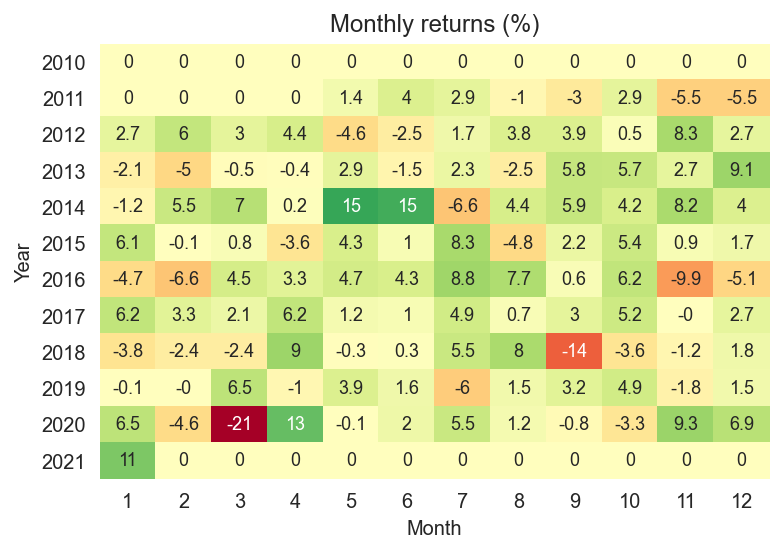

In [23]:
pf.plot_monthly_returns_heatmap(returns)

In [24]:
import dtale

In [25]:
returns.index = returns.index.to_pydatetime() 

In [26]:
dtale.show(returns, ignore_duplicate=True)